# Classifying cell types with neural networks

In this notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset for Shekhar et al., 2016. These cells have been manually annotated, and here we will show that a neural network can recapitulate these cell type labels.

## 1. Imports

In [1]:
!pip install scprep

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [3]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [4]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [5]:
data = scprep.reduce.pca(data_raw, n_components=50, method='dense').to_numpy()
data

array([[ -2.86639095,  16.11995588,   4.3694318 , ...,  -0.56813061,
          1.46639396,  -0.62288821],
       [ -0.66863206,  13.21553129,  -4.89263856, ...,  -0.63891561,
         -0.59564074,   2.97777505],
       [  0.29665496,   6.85551504,  18.19106767, ...,  -0.61296192,
          0.27695993,  -2.21230832],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.16420644, ...,  -2.441112  ,
          0.61532383,  -1.19892613],
       [  3.13934964,  15.10619606,   3.69472785, ...,  -2.3039714 ,
          0.18734215,   1.1257481 ],
       [ 42.90597659,  -9.79281524, -13.25214999, ...,   2.11989313,
          1.60726923,   0.281805  ]])

For easier classification, we'll scale the data to have mean 0 and standard deviation 1 across all features.

In [6]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)
data

array([[-0.17060225,  1.43324626,  0.61033178, ..., -0.2565225 ,
         0.66384181, -0.28285996],
       [-0.03979573,  1.17501009, -0.68341444, ..., -0.28848337,
        -0.2696487 ,  1.35223836],
       [ 0.01765635,  0.60953277,  2.54096807, ..., -0.27676475,
         0.12538076, -1.00463203],
       ...,
       [ 2.35163964, -0.72986086, -1.41975856, ..., -1.10221162,
         0.2785593 , -0.54444472],
       [ 0.18684824,  1.34311156,  0.51608766, ..., -1.04028985,
         0.08481046,  0.51121382],
       [ 2.55368378, -0.87069195, -1.85108926, ...,  0.95717478,
         0.72761655,  0.12797056]])

In [7]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

array([ 0,  1,  2, ..., 20, 20, 20])

In [8]:
num_classes = len(np.unique(labels))
num_classes

29

#### Splitting the data into training and validation sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [9]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

((17241, 50), (4311, 50))

## 3. Moving Our Data to PyTorch Tensors 

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available. 

In [10]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [11]:
# check shapes
print("train tensor shape: {}".format(train_tensor.shape))
print("train labels shape: {}".format(train_labels.shape))

print("valid tensor shape: {}".format(valid_tensor.shape))
print("valid labels shape: {}".format(valid_labels.shape))

train tensor shape: torch.Size([17241, 50])
train labels shape: torch.Size([17241])
valid tensor shape: torch.Size([4311, 50])
valid labels shape: torch.Size([4311])


## Exercise 1 - Tensor Operations 1

1. Create a tensor called x of values (1,20) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [12]:
# create x using torch.arange()
x = torch.arange(20)

# reshape to (4,5)
x = x.reshape(4,5)

# add 5
y = x + 5

# power y to the 3rd power
z = y ** 3

# print the first row of z
print(z[0])

tensor([125, 216, 343, 512, 729])


## Exercise 2 - Tensor Operations 2

1. Subset the training tensor by taking the last 5 rows

2. Double the values and print the result.


In [13]:
# Get the last five rows of `data_training`
data_last5 = train_tensor[-5:]

# Multiply by two
last5_double = train_tensor * 2

# Print the result
last5_double

tensor([[-0.3412,  2.8665,  1.2207,  ..., -0.5130,  1.3277, -0.5657],
        [-0.0796,  2.3500, -1.3668,  ..., -0.5770, -0.5393,  2.7045],
        [ 0.0353,  1.2191,  5.0819,  ..., -0.5535,  0.2508, -2.0093],
        ...,
        [-1.7015, -1.1584, -0.5822,  ..., -2.8309,  1.9023, -0.6938],
        [-0.0603,  2.7984, -0.2152,  ..., -2.2814, -2.1539,  0.7764],
        [-1.6173, -1.6872,  0.4320,  ..., -0.2860,  1.3147,  0.0669]],
       dtype=torch.float64)

## 4. Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [14]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [15]:
input_size = data_training.shape[1]
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output

tensor([[6.1641e-08, 1.2613e-04, 1.9029e-01,  ..., 5.0012e-09, 2.3979e-06,
         2.7323e-12],
        [5.0398e-06, 3.2500e-12, 9.9209e-07,  ..., 1.1637e-09, 2.9851e-09,
         6.5947e-12],
        [2.1990e-17, 9.9577e-19, 2.2788e-16,  ..., 6.2369e-14, 1.7504e-16,
         1.9059e-12],
        ...,
        [1.4355e-12, 5.5028e-07, 1.4903e-06,  ..., 9.6162e-12, 3.7306e-10,
         1.0731e-08],
        [3.5907e-04, 1.2010e-02, 2.6132e-02,  ..., 1.5581e-04, 1.0443e-02,
         8.2650e-03],
        [1.0854e-16, 2.0222e-05, 2.7706e-13,  ..., 1.3970e-17, 1.2456e-14,
         5.4094e-06]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Build the loss function

In order to train our neural network, we need to define a loss function which tells us how well (or how poorly) our classifier performed.

Here, we'll use the cross-entropy loss which we discussed in lecture.

In [16]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [17]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [18]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

tensor(278380.2728, dtype=torch.float64, grad_fn=<MulBackward0>)

#### Creating a model with PyTorch

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for PyTorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters to be optimized.

In [19]:
model = nn.Sequential(layer_1, layer_2)
print(model)

Sequential(
  (0): layer(
    (activation): ReLU()
  )
  (1): layer(
    (activation): Softmax(dim=-1)
  )
)


We can now obtain the output of our model by simply calling `model(data)`.

In [20]:
model(train_tensor)

tensor([[6.1641e-08, 1.2613e-04, 1.9029e-01,  ..., 5.0012e-09, 2.3979e-06,
         2.7323e-12],
        [5.0398e-06, 3.2500e-12, 9.9209e-07,  ..., 1.1637e-09, 2.9851e-09,
         6.5947e-12],
        [2.1990e-17, 9.9577e-19, 2.2788e-16,  ..., 6.2369e-14, 1.7504e-16,
         1.9059e-12],
        ...,
        [1.4355e-12, 5.5028e-07, 1.4903e-06,  ..., 9.6162e-12, 3.7306e-10,
         1.0731e-08],
        [3.5907e-04, 1.2010e-02, 2.6132e-02,  ..., 1.5581e-04, 1.0443e-02,
         8.2650e-03],
        [1.0854e-16, 2.0222e-05, 2.7706e-13,  ..., 1.3970e-17, 1.2456e-14,
         5.4094e-06]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Create the optimizer

To update the model parameters, PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [21]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 128

#### Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [22]:
# train the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(100):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 1007.463 training accuracy: 0.372 validation accuracy: 0.202 
Step 100 loss: 712.760 training accuracy: 0.398 validation accuracy: 0.340 
Step 150 loss: 515.526 training accuracy: 0.519 validation accuracy: 0.422 
Step 200 loss: 307.577 training accuracy: 0.620 validation accuracy: 0.516 
Step 250 loss: 233.070 training accuracy: 0.672 validation accuracy: 0.552 
Step 300 loss: 262.550 training accuracy: 0.682 validation accuracy: 0.618 
Step 350 loss: 329.483 training accuracy: 0.667 validation accuracy: 0.638 
Step 400 loss: 221.393 training accuracy: 0.727 validation accuracy: 0.661 
Step 450 loss: 184.304 training accuracy: 0.775 validation accuracy: 0.673 
Step 500 loss: 216.559 training accuracy: 0.781 validation accuracy: 0.688 
Step 550 loss: 277.085 training accuracy: 0.713 validation accuracy: 0.684 
Step 600 loss: 224.962 training accuracy: 0.705 validation accuracy: 0.685 
Step 650 loss: 169.396 training accuracy: 0.797 validation accuracy: 0.708 
Step 700 los

Step 5450 loss: 66.642 training accuracy: 0.898 validation accuracy: 0.869 
Step 5500 loss: 92.373 training accuracy: 0.845 validation accuracy: 0.868 
Step 5550 loss: 58.731 training accuracy: 0.899 validation accuracy: 0.868 
Step 5600 loss: 49.197 training accuracy: 0.930 validation accuracy: 0.866 
Step 5650 loss: 61.362 training accuracy: 0.899 validation accuracy: 0.870 
Step 5700 loss: 46.166 training accuracy: 0.930 validation accuracy: 0.869 
Step 5750 loss: 48.290 training accuracy: 0.914 validation accuracy: 0.871 
Step 5800 loss: 60.859 training accuracy: 0.899 validation accuracy: 0.872 
Step 5850 loss: 59.001 training accuracy: 0.915 validation accuracy: 0.869 
Step 5900 loss: 58.531 training accuracy: 0.930 validation accuracy: 0.869 
Step 5950 loss: 84.933 training accuracy: 0.868 validation accuracy: 0.873 
Step 6000 loss: 79.258 training accuracy: 0.867 validation accuracy: 0.869 
Step 6050 loss: 104.050 training accuracy: 0.853 validation accuracy: 0.873 
Step 6100 l

Step 10850 loss: 45.038 training accuracy: 0.945 validation accuracy: 0.870 
Step 10900 loss: 56.124 training accuracy: 0.938 validation accuracy: 0.871 
Step 10950 loss: 51.647 training accuracy: 0.898 validation accuracy: 0.874 
Step 11000 loss: 70.007 training accuracy: 0.922 validation accuracy: 0.874 
Step 11050 loss: 54.092 training accuracy: 0.922 validation accuracy: 0.874 
Step 11100 loss: 63.541 training accuracy: 0.914 validation accuracy: 0.867 
Step 11150 loss: 79.948 training accuracy: 0.853 validation accuracy: 0.875 
Step 11200 loss: 67.006 training accuracy: 0.899 validation accuracy: 0.878 
Step 11250 loss: 37.221 training accuracy: 0.945 validation accuracy: 0.870 
Step 11300 loss: 45.853 training accuracy: 0.946 validation accuracy: 0.872 
Step 11350 loss: 44.007 training accuracy: 0.938 validation accuracy: 0.869 
Step 11400 loss: 56.765 training accuracy: 0.938 validation accuracy: 0.870 
Step 11450 loss: 50.813 training accuracy: 0.899 validation accuracy: 0.869 

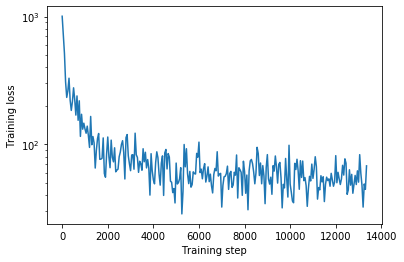

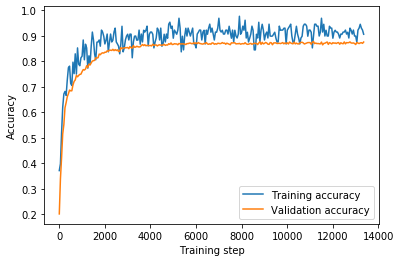

In [23]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did our network do? Is the classification accuracy high? 
    - The classification accuracy is pretty good -- it got to about 85%.
2. How many iterations did it take for the training accuracy to stop increasing?
    - The training accuracy converged after around 6,000 steps.
3. How many iterations did it take for the training loss to stop decreasing?
    - The training accuracy converged after around 10,000 steps.
4. How many iterations did it take for the validation accuracy to stop increasing?
    - The validation accuracy converged after around 3,000 steps.

## Exercise 3 - network width

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built.

In [24]:
# let's set some hyperparameters
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider hidden layer
num_hidden = 100
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2)

# create the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2858.558 training accuracy: 0.047 validation accuracy: 0.063 
Step 100 loss: 1883.764 training accuracy: 0.414 validation accuracy: 0.298 
Step 150 loss: 1323.104 training accuracy: 0.581 validation accuracy: 0.442 
Step 200 loss: 1314.971 training accuracy: 0.566 validation accuracy: 0.530 
Step 250 loss: 1122.406 training accuracy: 0.617 validation accuracy: 0.556 
Step 300 loss: 925.293 training accuracy: 0.705 validation accuracy: 0.622 
Step 350 loss: 970.968 training accuracy: 0.682 validation accuracy: 0.653 
Step 400 loss: 816.185 training accuracy: 0.734 validation accuracy: 0.670 
Step 450 loss: 708.865 training accuracy: 0.775 validation accuracy: 0.676 
Step 500 loss: 707.581 training accuracy: 0.789 validation accuracy: 0.690 
Step 550 loss: 868.091 training accuracy: 0.729 validation accuracy: 0.702 
Step 600 loss: 797.025 training accuracy: 0.744 validation accuracy: 0.710 
Step 650 loss: 631.705 training accuracy: 0.805 validation accuracy: 0.716 
Step 700

Step 5450 loss: 548.387 training accuracy: 0.820 validation accuracy: 0.765 
Step 5500 loss: 589.122 training accuracy: 0.798 validation accuracy: 0.763 
Step 5550 loss: 485.423 training accuracy: 0.822 validation accuracy: 0.764 
Step 5600 loss: 482.709 training accuracy: 0.844 validation accuracy: 0.763 
Step 5650 loss: 490.341 training accuracy: 0.822 validation accuracy: 0.765 
Step 5700 loss: 476.465 training accuracy: 0.845 validation accuracy: 0.765 
Step 5750 loss: 400.404 training accuracy: 0.859 validation accuracy: 0.763 
Step 5800 loss: 509.665 training accuracy: 0.837 validation accuracy: 0.764 
Step 5850 loss: 453.771 training accuracy: 0.837 validation accuracy: 0.764 
Step 5900 loss: 329.865 training accuracy: 0.891 validation accuracy: 0.762 
Step 5950 loss: 420.726 training accuracy: 0.860 validation accuracy: 0.763 
Step 6000 loss: 644.292 training accuracy: 0.781 validation accuracy: 0.761 
Step 6050 loss: 456.086 training accuracy: 0.829 validation accuracy: 0.763 

Step 10850 loss: 472.428 training accuracy: 0.844 validation accuracy: 0.760 
Step 10900 loss: 501.412 training accuracy: 0.829 validation accuracy: 0.759 
Step 10950 loss: 473.409 training accuracy: 0.836 validation accuracy: 0.762 
Step 11000 loss: 505.830 training accuracy: 0.822 validation accuracy: 0.761 
Step 11050 loss: 499.037 training accuracy: 0.806 validation accuracy: 0.759 
Step 11100 loss: 522.619 training accuracy: 0.797 validation accuracy: 0.759 
Step 11150 loss: 539.301 training accuracy: 0.814 validation accuracy: 0.763 
Step 11200 loss: 302.450 training accuracy: 0.891 validation accuracy: 0.759 
Step 11250 loss: 276.034 training accuracy: 0.891 validation accuracy: 0.763 
Step 11300 loss: 452.694 training accuracy: 0.853 validation accuracy: 0.761 
Step 11350 loss: 408.572 training accuracy: 0.852 validation accuracy: 0.762 
Step 11400 loss: 399.007 training accuracy: 0.845 validation accuracy: 0.759 
Step 11450 loss: 412.470 training accuracy: 0.853 validation acc

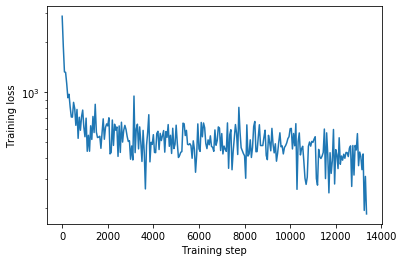

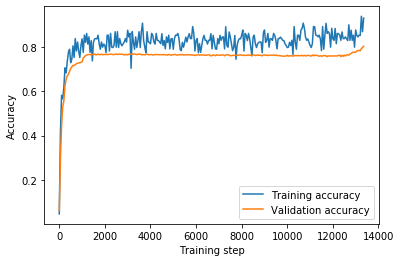

In [25]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - optimizers

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [26]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2)

# =========
# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)
# =========

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2402.951 training accuracy: 0.062 validation accuracy: 0.033 
Step 100 loss: 2340.923 training accuracy: 0.031 validation accuracy: 0.041 
Step 150 loss: 2243.739 training accuracy: 0.054 validation accuracy: 0.050 
Step 200 loss: 2182.295 training accuracy: 0.039 validation accuracy: 0.058 
Step 250 loss: 2056.511 training accuracy: 0.109 validation accuracy: 0.067 
Step 300 loss: 2029.666 training accuracy: 0.085 validation accuracy: 0.077 
Step 350 loss: 1877.899 training accuracy: 0.147 validation accuracy: 0.088 
Step 400 loss: 1846.524 training accuracy: 0.172 validation accuracy: 0.102 
Step 450 loss: 1715.620 training accuracy: 0.209 validation accuracy: 0.128 
Step 500 loss: 1449.369 training accuracy: 0.281 validation accuracy: 0.151 
Step 550 loss: 1463.678 training accuracy: 0.287 validation accuracy: 0.177 
Step 600 loss: 1366.799 training accuracy: 0.326 validation accuracy: 0.199 
Step 650 loss: 1422.971 training accuracy: 0.289 validation accuracy: 0.223 


Step 5450 loss: 129.630 training accuracy: 0.859 validation accuracy: 0.789 
Step 5500 loss: 69.328 training accuracy: 0.930 validation accuracy: 0.787 
Step 5550 loss: 105.440 training accuracy: 0.899 validation accuracy: 0.790 
Step 5600 loss: 114.735 training accuracy: 0.875 validation accuracy: 0.791 
Step 5650 loss: 133.932 training accuracy: 0.884 validation accuracy: 0.791 
Step 5700 loss: 123.968 training accuracy: 0.860 validation accuracy: 0.794 
Step 5750 loss: 79.286 training accuracy: 0.883 validation accuracy: 0.794 
Step 5800 loss: 112.167 training accuracy: 0.884 validation accuracy: 0.793 
Step 5850 loss: 89.262 training accuracy: 0.876 validation accuracy: 0.796 
Step 5900 loss: 115.065 training accuracy: 0.907 validation accuracy: 0.796 
Step 5950 loss: 127.907 training accuracy: 0.845 validation accuracy: 0.796 
Step 6000 loss: 106.347 training accuracy: 0.852 validation accuracy: 0.799 
Step 6050 loss: 167.030 training accuracy: 0.845 validation accuracy: 0.801 
St

Step 10850 loss: 81.147 training accuracy: 0.906 validation accuracy: 0.855 
Step 10900 loss: 67.046 training accuracy: 0.930 validation accuracy: 0.857 
Step 10950 loss: 39.565 training accuracy: 0.922 validation accuracy: 0.859 
Step 11000 loss: 57.954 training accuracy: 0.938 validation accuracy: 0.859 
Step 11050 loss: 102.693 training accuracy: 0.915 validation accuracy: 0.857 
Step 11100 loss: 48.322 training accuracy: 0.938 validation accuracy: 0.857 
Step 11150 loss: 98.101 training accuracy: 0.884 validation accuracy: 0.856 
Step 11200 loss: 54.419 training accuracy: 0.953 validation accuracy: 0.858 
Step 11250 loss: 98.029 training accuracy: 0.922 validation accuracy: 0.858 
Step 11300 loss: 126.643 training accuracy: 0.868 validation accuracy: 0.860 
Step 11350 loss: 56.070 training accuracy: 0.961 validation accuracy: 0.857 
Step 11400 loss: 62.280 training accuracy: 0.899 validation accuracy: 0.858 
Step 11450 loss: 97.352 training accuracy: 0.891 validation accuracy: 0.85

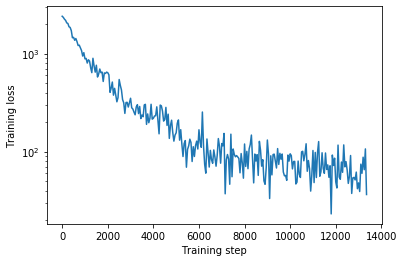

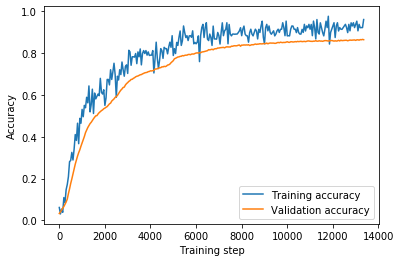

In [27]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - network depth

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built. Try increasing the number of epochs if the loss hasn't stopped increasing.

In [28]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
# ========
# Create an additional hidden layer
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
# ========
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 3061.664 training accuracy: 0.047 validation accuracy: 0.028 
Step 100 loss: 2675.661 training accuracy: 0.117 validation accuracy: 0.037 
Step 150 loss: 2655.611 training accuracy: 0.163 validation accuracy: 0.061 
Step 200 loss: 2525.174 training accuracy: 0.217 validation accuracy: 0.099 
Step 250 loss: 2265.507 training accuracy: 0.297 validation accuracy: 0.138 
Step 300 loss: 2154.993 training accuracy: 0.333 validation accuracy: 0.163 
Step 350 loss: 2197.376 training accuracy: 0.333 validation accuracy: 0.183 
Step 400 loss: 2027.511 training accuracy: 0.367 validation accuracy: 0.192 
Step 450 loss: 2195.757 training accuracy: 0.326 validation accuracy: 0.203 
Step 500 loss: 2121.725 training accuracy: 0.352 validation accuracy: 0.211 
Step 550 loss: 1972.080 training accuracy: 0.403 validation accuracy: 0.216 
Step 600 loss: 1909.807 training accuracy: 0.419 validation accuracy: 0.220 
Step 650 loss: 1849.995 training accuracy: 0.422 validation accuracy: 0.223 


Step 5450 loss: 868.914 training accuracy: 0.648 validation accuracy: 0.524 
Step 5500 loss: 742.179 training accuracy: 0.667 validation accuracy: 0.530 
Step 5550 loss: 787.467 training accuracy: 0.690 validation accuracy: 0.533 
Step 5600 loss: 1005.849 training accuracy: 0.609 validation accuracy: 0.531 
Step 5650 loss: 830.171 training accuracy: 0.628 validation accuracy: 0.537 
Step 5700 loss: 1012.958 training accuracy: 0.605 validation accuracy: 0.543 
Step 5750 loss: 820.208 training accuracy: 0.688 validation accuracy: 0.545 
Step 5800 loss: 909.197 training accuracy: 0.636 validation accuracy: 0.545 
Step 5850 loss: 773.315 training accuracy: 0.682 validation accuracy: 0.547 
Step 5900 loss: 688.750 training accuracy: 0.682 validation accuracy: 0.548 
Step 5950 loss: 790.640 training accuracy: 0.674 validation accuracy: 0.551 
Step 6000 loss: 595.455 training accuracy: 0.766 validation accuracy: 0.551 
Step 6050 loss: 709.776 training accuracy: 0.729 validation accuracy: 0.55

Step 10850 loss: 325.481 training accuracy: 0.812 validation accuracy: 0.692 
Step 10900 loss: 175.244 training accuracy: 0.868 validation accuracy: 0.693 
Step 10950 loss: 272.819 training accuracy: 0.789 validation accuracy: 0.687 
Step 11000 loss: 274.345 training accuracy: 0.814 validation accuracy: 0.695 
Step 11050 loss: 354.032 training accuracy: 0.806 validation accuracy: 0.693 
Step 11100 loss: 271.887 training accuracy: 0.773 validation accuracy: 0.696 
Step 11150 loss: 311.771 training accuracy: 0.814 validation accuracy: 0.693 
Step 11200 loss: 255.843 training accuracy: 0.798 validation accuracy: 0.699 
Step 11250 loss: 358.591 training accuracy: 0.797 validation accuracy: 0.699 
Step 11300 loss: 239.373 training accuracy: 0.829 validation accuracy: 0.695 
Step 11350 loss: 354.040 training accuracy: 0.766 validation accuracy: 0.697 
Step 11400 loss: 250.359 training accuracy: 0.822 validation accuracy: 0.700 
Step 11450 loss: 300.585 training accuracy: 0.760 validation acc

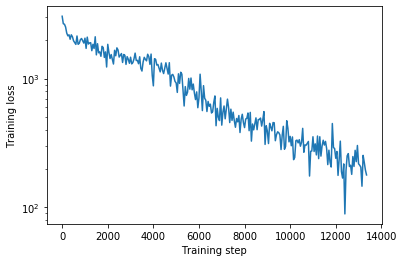

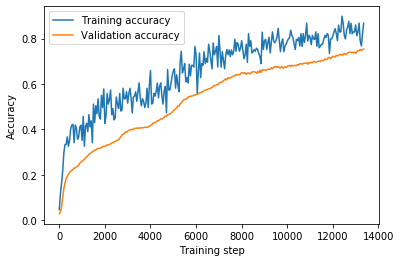

In [29]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 5 - activation functions

PyTorch provides a number of different activations for us to choose from. Replace `nn.ReLU` with any of `nn.Tanh`, `nn.Sigmoid` and `nn.LeakyReLU` or any others you find in the PyTorch docs to build the best possible network.

In [35]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2798.751 training accuracy: 0.085 validation accuracy: 0.094 
Step 100 loss: 2644.166 training accuracy: 0.148 validation accuracy: 0.135 
Step 150 loss: 2374.426 training accuracy: 0.209 validation accuracy: 0.159 
Step 200 loss: 2257.091 training accuracy: 0.256 validation accuracy: 0.179 
Step 250 loss: 2192.079 training accuracy: 0.242 validation accuracy: 0.202 
Step 300 loss: 2196.675 training accuracy: 0.264 validation accuracy: 0.212 
Step 350 loss: 2030.334 training accuracy: 0.349 validation accuracy: 0.221 
Step 400 loss: 2023.062 training accuracy: 0.312 validation accuracy: 0.230 
Step 450 loss: 1932.273 training accuracy: 0.333 validation accuracy: 0.237 
Step 500 loss: 1874.257 training accuracy: 0.367 validation accuracy: 0.241 
Step 550 loss: 1953.721 training accuracy: 0.364 validation accuracy: 0.244 
Step 600 loss: 1776.373 training accuracy: 0.395 validation accuracy: 0.252 
Step 650 loss: 1918.070 training accuracy: 0.352 validation accuracy: 0.253 


Step 5400 loss: 357.120 training accuracy: 0.760 validation accuracy: 0.607 
Step 5450 loss: 373.219 training accuracy: 0.734 validation accuracy: 0.606 
Step 5500 loss: 588.765 training accuracy: 0.636 validation accuracy: 0.609 
Step 5550 loss: 495.862 training accuracy: 0.690 validation accuracy: 0.609 
Step 5600 loss: 352.392 training accuracy: 0.742 validation accuracy: 0.613 
Step 5650 loss: 457.014 training accuracy: 0.705 validation accuracy: 0.613 
Step 5700 loss: 534.597 training accuracy: 0.612 validation accuracy: 0.614 
Step 5750 loss: 428.751 training accuracy: 0.758 validation accuracy: 0.618 
Step 5800 loss: 482.856 training accuracy: 0.674 validation accuracy: 0.620 
Step 5850 loss: 338.167 training accuracy: 0.752 validation accuracy: 0.618 
Step 5900 loss: 322.188 training accuracy: 0.791 validation accuracy: 0.624 
Step 5950 loss: 267.898 training accuracy: 0.791 validation accuracy: 0.622 
Step 6000 loss: 418.114 training accuracy: 0.711 validation accuracy: 0.625 

Step 10800 loss: 189.083 training accuracy: 0.860 validation accuracy: 0.753 
Step 10850 loss: 225.115 training accuracy: 0.836 validation accuracy: 0.755 
Step 10900 loss: 171.787 training accuracy: 0.899 validation accuracy: 0.756 
Step 10950 loss: 157.964 training accuracy: 0.875 validation accuracy: 0.754 
Step 11000 loss: 185.518 training accuracy: 0.876 validation accuracy: 0.756 
Step 11050 loss: 172.690 training accuracy: 0.884 validation accuracy: 0.756 
Step 11100 loss: 263.813 training accuracy: 0.805 validation accuracy: 0.759 
Step 11150 loss: 127.255 training accuracy: 0.884 validation accuracy: 0.757 
Step 11200 loss: 243.510 training accuracy: 0.791 validation accuracy: 0.757 
Step 11250 loss: 150.244 training accuracy: 0.852 validation accuracy: 0.757 
Step 11300 loss: 216.629 training accuracy: 0.853 validation accuracy: 0.760 
Step 11350 loss: 195.611 training accuracy: 0.844 validation accuracy: 0.763 
Step 11400 loss: 240.191 training accuracy: 0.829 validation acc

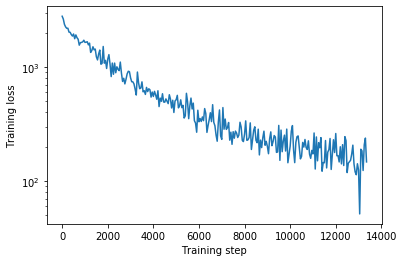

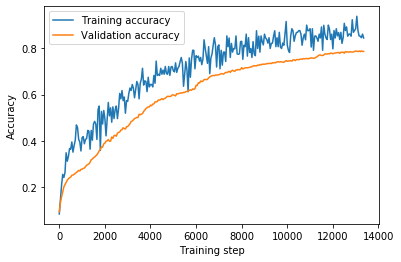

In [36]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 6 - more network depth

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [33]:
# ======
# Create a five-layer network based on the code in the exercise above
# let's set some hyperparameters
batch_size = 128
# ========
# as you add further additional layers, you may wish to decrease the learning rate, e.g. to 0.0001
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.0001
n_epochs = 500
# ========
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())

# Create additional hidden layers
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_4 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_5 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 3468.510 training accuracy: 0.023 validation accuracy: 0.016 
Step 100 loss: 3448.069 training accuracy: 0.023 validation accuracy: 0.017 
Step 150 loss: 3512.123 training accuracy: 0.008 validation accuracy: 0.016 
Step 200 loss: 3450.081 training accuracy: 0.016 validation accuracy: 0.016 
Step 250 loss: 3508.897 training accuracy: 0.008 validation accuracy: 0.016 
Step 300 loss: 3521.010 training accuracy: 0.008 validation accuracy: 0.017 
Step 350 loss: 3510.319 training accuracy: 0.008 validation accuracy: 0.017 
Step 400 loss: 3508.463 training accuracy: 0.008 validation accuracy: 0.017 
Step 450 loss: 3499.403 training accuracy: 0.008 validation accuracy: 0.017 
Step 500 loss: 3436.947 training accuracy: 0.016 validation accuracy: 0.017 
Step 550 loss: 3533.011 training accuracy: 0.008 validation accuracy: 0.017 
Step 600 loss: 3542.942 training accuracy: 0.000 validation accuracy: 0.017 
Step 650 loss: 3495.915 training accuracy: 0.008 validation accuracy: 0.017 


Step 5350 loss: 3458.756 training accuracy: 0.016 validation accuracy: 0.018 
Step 5400 loss: 3449.834 training accuracy: 0.031 validation accuracy: 0.018 
Step 5450 loss: 3481.505 training accuracy: 0.016 validation accuracy: 0.018 
Step 5500 loss: 3431.681 training accuracy: 0.031 validation accuracy: 0.018 
Step 5550 loss: 3509.135 training accuracy: 0.016 validation accuracy: 0.018 
Step 5600 loss: 3461.373 training accuracy: 0.016 validation accuracy: 0.018 
Step 5650 loss: 3528.620 training accuracy: 0.000 validation accuracy: 0.018 
Step 5700 loss: 3446.996 training accuracy: 0.023 validation accuracy: 0.018 
Step 5750 loss: 3478.395 training accuracy: 0.016 validation accuracy: 0.018 
Step 5800 loss: 3557.833 training accuracy: 0.000 validation accuracy: 0.018 
Step 5850 loss: 3505.224 training accuracy: 0.008 validation accuracy: 0.018 
Step 5900 loss: 3536.767 training accuracy: 0.008 validation accuracy: 0.018 
Step 5950 loss: 3487.007 training accuracy: 0.008 validation acc

Step 10650 loss: 3530.998 training accuracy: 0.008 validation accuracy: 0.019 
Step 10700 loss: 3488.134 training accuracy: 0.008 validation accuracy: 0.019 
Step 10750 loss: 3494.798 training accuracy: 0.000 validation accuracy: 0.019 
Step 10800 loss: 3490.356 training accuracy: 0.016 validation accuracy: 0.019 
Step 10850 loss: 3401.753 training accuracy: 0.031 validation accuracy: 0.019 
Step 10900 loss: 3404.061 training accuracy: 0.031 validation accuracy: 0.019 
Step 10950 loss: 3461.190 training accuracy: 0.016 validation accuracy: 0.019 
Step 11000 loss: 3508.310 training accuracy: 0.000 validation accuracy: 0.019 
Step 11050 loss: 3495.789 training accuracy: 0.008 validation accuracy: 0.019 
Step 11100 loss: 3396.992 training accuracy: 0.016 validation accuracy: 0.019 
Step 11150 loss: 3560.498 training accuracy: 0.000 validation accuracy: 0.019 
Step 11200 loss: 3408.332 training accuracy: 0.023 validation accuracy: 0.019 
Step 11250 loss: 3393.034 training accuracy: 0.031 v

Step 15850 loss: 3421.315 training accuracy: 0.023 validation accuracy: 0.019 
Step 15900 loss: 3505.248 training accuracy: 0.008 validation accuracy: 0.019 
Step 15950 loss: 3495.927 training accuracy: 0.000 validation accuracy: 0.019 
Step 16000 loss: 3520.664 training accuracy: 0.000 validation accuracy: 0.019 
Step 16050 loss: 3436.573 training accuracy: 0.016 validation accuracy: 0.019 
Step 16100 loss: 3421.050 training accuracy: 0.023 validation accuracy: 0.019 
Step 16150 loss: 3466.550 training accuracy: 0.008 validation accuracy: 0.019 
Step 16200 loss: 3399.369 training accuracy: 0.016 validation accuracy: 0.019 
Step 16250 loss: 3419.237 training accuracy: 0.023 validation accuracy: 0.019 
Step 16300 loss: 3393.445 training accuracy: 0.031 validation accuracy: 0.019 
Step 16350 loss: 3446.096 training accuracy: 0.023 validation accuracy: 0.019 
Step 16400 loss: 3427.067 training accuracy: 0.031 validation accuracy: 0.019 
Step 16450 loss: 3412.108 training accuracy: 0.031 v

Step 21050 loss: 3550.084 training accuracy: 0.000 validation accuracy: 0.019 
Step 21100 loss: 3429.369 training accuracy: 0.016 validation accuracy: 0.019 
Step 21150 loss: 3401.850 training accuracy: 0.016 validation accuracy: 0.019 
Step 21200 loss: 3419.498 training accuracy: 0.031 validation accuracy: 0.019 
Step 21250 loss: 3459.611 training accuracy: 0.008 validation accuracy: 0.019 
Step 21300 loss: 3428.048 training accuracy: 0.008 validation accuracy: 0.019 
Step 21350 loss: 3398.260 training accuracy: 0.031 validation accuracy: 0.019 
Step 21400 loss: 3411.880 training accuracy: 0.008 validation accuracy: 0.019 
Step 21450 loss: 3372.830 training accuracy: 0.039 validation accuracy: 0.019 
Step 21500 loss: 3368.871 training accuracy: 0.039 validation accuracy: 0.019 
Step 21550 loss: 3375.472 training accuracy: 0.031 validation accuracy: 0.019 
Step 21600 loss: 3445.640 training accuracy: 0.016 validation accuracy: 0.019 
Step 21650 loss: 3451.492 training accuracy: 0.008 v

Step 26250 loss: 3396.873 training accuracy: 0.016 validation accuracy: 0.019 
Step 26300 loss: 3507.630 training accuracy: 0.008 validation accuracy: 0.019 
Step 26350 loss: 3392.666 training accuracy: 0.023 validation accuracy: 0.019 
Step 26400 loss: 3472.687 training accuracy: 0.016 validation accuracy: 0.019 
Step 26450 loss: 3540.160 training accuracy: 0.000 validation accuracy: 0.019 
Step 26500 loss: 3344.427 training accuracy: 0.039 validation accuracy: 0.019 
Step 26550 loss: 3464.420 training accuracy: 0.016 validation accuracy: 0.019 
Step 26600 loss: 3471.815 training accuracy: 0.008 validation accuracy: 0.019 
Step 26650 loss: 3384.410 training accuracy: 0.023 validation accuracy: 0.019 
Step 26700 loss: 3487.345 training accuracy: 0.008 validation accuracy: 0.019 
Step 26750 loss: 3467.982 training accuracy: 0.008 validation accuracy: 0.019 
Step 26800 loss: 3372.172 training accuracy: 0.031 validation accuracy: 0.019 
Step 26850 loss: 3476.181 training accuracy: 0.016 v

Step 31450 loss: 3486.033 training accuracy: 0.000 validation accuracy: 0.019 
Step 31500 loss: 3431.885 training accuracy: 0.016 validation accuracy: 0.019 
Step 31550 loss: 3561.152 training accuracy: 0.000 validation accuracy: 0.019 
Step 31600 loss: 3397.959 training accuracy: 0.016 validation accuracy: 0.019 
Step 31650 loss: 3422.901 training accuracy: 0.008 validation accuracy: 0.019 
Step 31700 loss: 3476.422 training accuracy: 0.008 validation accuracy: 0.019 
Step 31750 loss: 3428.807 training accuracy: 0.000 validation accuracy: 0.019 
Step 31800 loss: 3378.871 training accuracy: 0.023 validation accuracy: 0.019 
Step 31850 loss: 3391.207 training accuracy: 0.031 validation accuracy: 0.019 
Step 31900 loss: 3456.957 training accuracy: 0.016 validation accuracy: 0.019 
Step 31950 loss: 3365.829 training accuracy: 0.031 validation accuracy: 0.019 
Step 32000 loss: 3440.196 training accuracy: 0.016 validation accuracy: 0.019 
Step 32050 loss: 3408.972 training accuracy: 0.031 v

Step 36650 loss: 3395.669 training accuracy: 0.031 validation accuracy: 0.019 
Step 36700 loss: 3361.250 training accuracy: 0.031 validation accuracy: 0.019 
Step 36750 loss: 3284.271 training accuracy: 0.054 validation accuracy: 0.019 
Step 36800 loss: 3442.989 training accuracy: 0.016 validation accuracy: 0.019 
Step 36850 loss: 3356.385 training accuracy: 0.016 validation accuracy: 0.019 
Step 36900 loss: 3418.951 training accuracy: 0.008 validation accuracy: 0.019 
Step 36950 loss: 3419.736 training accuracy: 0.023 validation accuracy: 0.019 
Step 37000 loss: 3373.095 training accuracy: 0.031 validation accuracy: 0.019 
Step 37050 loss: 3451.983 training accuracy: 0.016 validation accuracy: 0.019 
Step 37100 loss: 3389.470 training accuracy: 0.016 validation accuracy: 0.019 
Step 37150 loss: 3460.872 training accuracy: 0.008 validation accuracy: 0.019 
Step 37200 loss: 3421.059 training accuracy: 0.031 validation accuracy: 0.019 
Step 37250 loss: 3378.564 training accuracy: 0.008 v

Step 41850 loss: 3353.948 training accuracy: 0.047 validation accuracy: 0.019 
Step 41900 loss: 3479.756 training accuracy: 0.008 validation accuracy: 0.019 
Step 41950 loss: 3390.175 training accuracy: 0.031 validation accuracy: 0.019 
Step 42000 loss: 3486.963 training accuracy: 0.008 validation accuracy: 0.019 
Step 42050 loss: 3343.934 training accuracy: 0.031 validation accuracy: 0.019 
Step 42100 loss: 3466.927 training accuracy: 0.016 validation accuracy: 0.019 
Step 42150 loss: 3417.048 training accuracy: 0.016 validation accuracy: 0.019 
Step 42200 loss: 3430.942 training accuracy: 0.016 validation accuracy: 0.019 
Step 42250 loss: 3368.221 training accuracy: 0.031 validation accuracy: 0.019 
Step 42300 loss: 3472.902 training accuracy: 0.000 validation accuracy: 0.019 
Step 42350 loss: 3408.401 training accuracy: 0.008 validation accuracy: 0.019 
Step 42400 loss: 3469.423 training accuracy: 0.008 validation accuracy: 0.019 
Step 42450 loss: 3422.305 training accuracy: 0.008 v

Step 47050 loss: 3479.816 training accuracy: 0.016 validation accuracy: 0.019 
Step 47100 loss: 3492.278 training accuracy: 0.008 validation accuracy: 0.019 
Step 47150 loss: 3501.767 training accuracy: 0.000 validation accuracy: 0.019 
Step 47200 loss: 3461.611 training accuracy: 0.023 validation accuracy: 0.019 
Step 47250 loss: 3399.555 training accuracy: 0.031 validation accuracy: 0.019 
Step 47300 loss: 3425.570 training accuracy: 0.023 validation accuracy: 0.019 
Step 47350 loss: 3429.366 training accuracy: 0.016 validation accuracy: 0.019 
Step 47400 loss: 3431.821 training accuracy: 0.016 validation accuracy: 0.019 
Step 47450 loss: 3454.349 training accuracy: 0.008 validation accuracy: 0.019 
Step 47500 loss: 3451.229 training accuracy: 0.023 validation accuracy: 0.019 
Step 47550 loss: 3359.304 training accuracy: 0.023 validation accuracy: 0.019 
Step 47600 loss: 3461.321 training accuracy: 0.008 validation accuracy: 0.019 
Step 47650 loss: 3347.751 training accuracy: 0.039 v

Step 52250 loss: 3290.569 training accuracy: 0.039 validation accuracy: 0.019 
Step 52300 loss: 3489.802 training accuracy: 0.000 validation accuracy: 0.019 
Step 52350 loss: 3331.572 training accuracy: 0.023 validation accuracy: 0.019 
Step 52400 loss: 3432.498 training accuracy: 0.016 validation accuracy: 0.019 
Step 52450 loss: 3364.239 training accuracy: 0.039 validation accuracy: 0.019 
Step 52500 loss: 3266.143 training accuracy: 0.039 validation accuracy: 0.019 
Step 52550 loss: 3437.133 training accuracy: 0.023 validation accuracy: 0.019 
Step 52600 loss: 3449.911 training accuracy: 0.016 validation accuracy: 0.019 
Step 52650 loss: 3457.123 training accuracy: 0.016 validation accuracy: 0.019 
Step 52700 loss: 3456.917 training accuracy: 0.016 validation accuracy: 0.019 
Step 52750 loss: 3432.395 training accuracy: 0.016 validation accuracy: 0.019 
Step 52800 loss: 3457.928 training accuracy: 0.008 validation accuracy: 0.019 
Step 52850 loss: 3364.802 training accuracy: 0.039 v

Step 57450 loss: 3423.237 training accuracy: 0.008 validation accuracy: 0.019 
Step 57500 loss: 3441.984 training accuracy: 0.008 validation accuracy: 0.019 
Step 57550 loss: 3390.550 training accuracy: 0.031 validation accuracy: 0.019 
Step 57600 loss: 3450.960 training accuracy: 0.008 validation accuracy: 0.019 
Step 57650 loss: 3414.302 training accuracy: 0.023 validation accuracy: 0.019 
Step 57700 loss: 3420.028 training accuracy: 0.023 validation accuracy: 0.019 
Step 57750 loss: 3420.173 training accuracy: 0.023 validation accuracy: 0.019 
Step 57800 loss: 3461.907 training accuracy: 0.016 validation accuracy: 0.019 
Step 57850 loss: 3361.349 training accuracy: 0.008 validation accuracy: 0.019 
Step 57900 loss: 3503.880 training accuracy: 0.008 validation accuracy: 0.019 
Step 57950 loss: 3496.291 training accuracy: 0.008 validation accuracy: 0.019 
Step 58000 loss: 3502.358 training accuracy: 0.000 validation accuracy: 0.019 
Step 58050 loss: 3329.450 training accuracy: 0.039 v

Step 62650 loss: 3433.303 training accuracy: 0.016 validation accuracy: 0.019 
Step 62700 loss: 3381.134 training accuracy: 0.016 validation accuracy: 0.019 
Step 62750 loss: 3385.597 training accuracy: 0.023 validation accuracy: 0.019 
Step 62800 loss: 3492.923 training accuracy: 0.008 validation accuracy: 0.019 
Step 62850 loss: 3420.791 training accuracy: 0.023 validation accuracy: 0.019 
Step 62900 loss: 3454.704 training accuracy: 0.000 validation accuracy: 0.019 
Step 62950 loss: 3436.749 training accuracy: 0.008 validation accuracy: 0.019 
Step 63000 loss: 3464.149 training accuracy: 0.008 validation accuracy: 0.019 
Step 63050 loss: 3382.721 training accuracy: 0.039 validation accuracy: 0.019 
Step 63100 loss: 3339.583 training accuracy: 0.039 validation accuracy: 0.019 
Step 63150 loss: 3436.531 training accuracy: 0.008 validation accuracy: 0.019 
Step 63200 loss: 3447.707 training accuracy: 0.008 validation accuracy: 0.019 
Step 63250 loss: 3425.044 training accuracy: 0.023 v

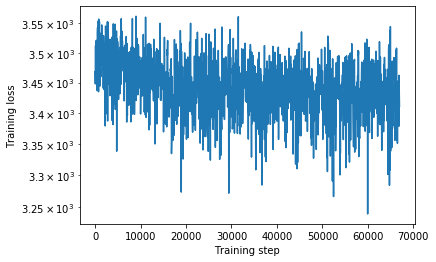

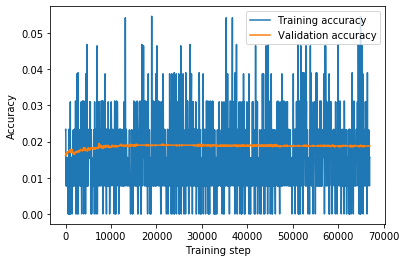

In [34]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did the more complex networks you built compare to the simple network we started with?
    - None of them really performed any better. The more complex networks took longer to train, and the deepest network failed to learn anything.
2. Which was more useful -- adding _depth_ to your network or adding width?
    - Adding _some_ depth is helpful, but too much can make training difficult. Adding too much width didn't help much.
3. Which optimizer performed best?
    - Adam performs best and has the smoothest convergence, though on the simpler networks SGD did surprisingly well.
4. What had the biggest effect on performance: depth, width, or optimizer?
    - The optimizer has the biggest effect.

#### Re-Cap
1. Power of PyTorch is to allow us to setup the neural networks using nn.Module

2. We can use the same neural network over and over with different data without having to re-write the code.